# ADS505 Final Project (Team 2)

## Required Packages

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


warnings.filterwarnings("ignore")

## Descriptive Analytics

In [2]:
# load the dataset
df = pd.read_csv('./Big_Black_Money_Dataset.csv')
df.head()

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,TX0000000001,Brazil,3.267530e+06,Offshore Transfer,2013-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore
1,TX0000000002,China,4.965767e+06,Stocks Transfer,2013-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas
2,TX0000000003,UK,9.416750e+04,Stocks Transfer,2013-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland
3,TX0000000004,UAE,3.864201e+05,Cash Withdrawal,2013-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama
4,TX0000000005,South Africa,6.433784e+05,Cryptocurrency,2013-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg


In [3]:
# Data Structure
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction ID               10000 non-null  object 
 1   Country                      10000 non-null  object 
 2   Amount (USD)                 10000 non-null  float64
 3   Transaction Type             10000 non-null  object 
 4   Date of Transaction          10000 non-null  object 
 5   Person Involved              10000 non-null  object 
 6   Industry                     10000 non-null  object 
 7   Destination Country          10000 non-null  object 
 8   Reported by Authority        10000 non-null  bool   
 9   Source of Money              10000 non-null  object 
 10  Money Laundering Risk Score  10000 non-null  int64  
 11  Shell Companies Involved     10000 non-null  int64  
 12  Financial Institution        10000 non-null  object 
 13  Tax Haven Country

In [4]:
# Convert 'Date of Transaction' to datetime
df['Date of Transaction'] = pd.to_datetime(df['Date of Transaction'], format='%Y-%m-%d %H:%M:%S')

# Convert datetime to seconds since epoch
df['Transaction_Seconds'] = (df['Date of Transaction'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


## Univariate Analysis

In [5]:
# Summary statistics
print(df.describe())
print()

# Unique Value Counts
print('Unique Column Values Count')
print('-------------------------------')
print(df.nunique())

       Amount (USD)  Date of Transaction  Money Laundering Risk Score  \
count  1.000000e+04                10000                 10000.000000   
mean   2.501818e+06  2013-07-28 07:30:00                     5.526400   
min    1.003180e+04  2013-01-01 00:00:00                     1.000000   
25%    1.279005e+06  2013-04-15 03:45:00                     3.000000   
50%    2.501310e+06  2013-07-28 07:30:00                     6.000000   
75%    3.722416e+06  2013-11-09 11:15:00                     8.000000   
max    4.999812e+06  2014-02-21 15:00:00                    10.000000   
std    1.424364e+06                  NaN                     2.893603   

       Shell Companies Involved  Transaction_Seconds  
count              10000.000000         1.000000e+04  
mean                   4.469400         1.374997e+09  
min                    0.000000         1.356998e+09  
25%                    2.000000         1.365998e+09  
50%                    4.000000         1.374997e+09  
75%         

## Multivariate Analysis

### Correlation Heatmap

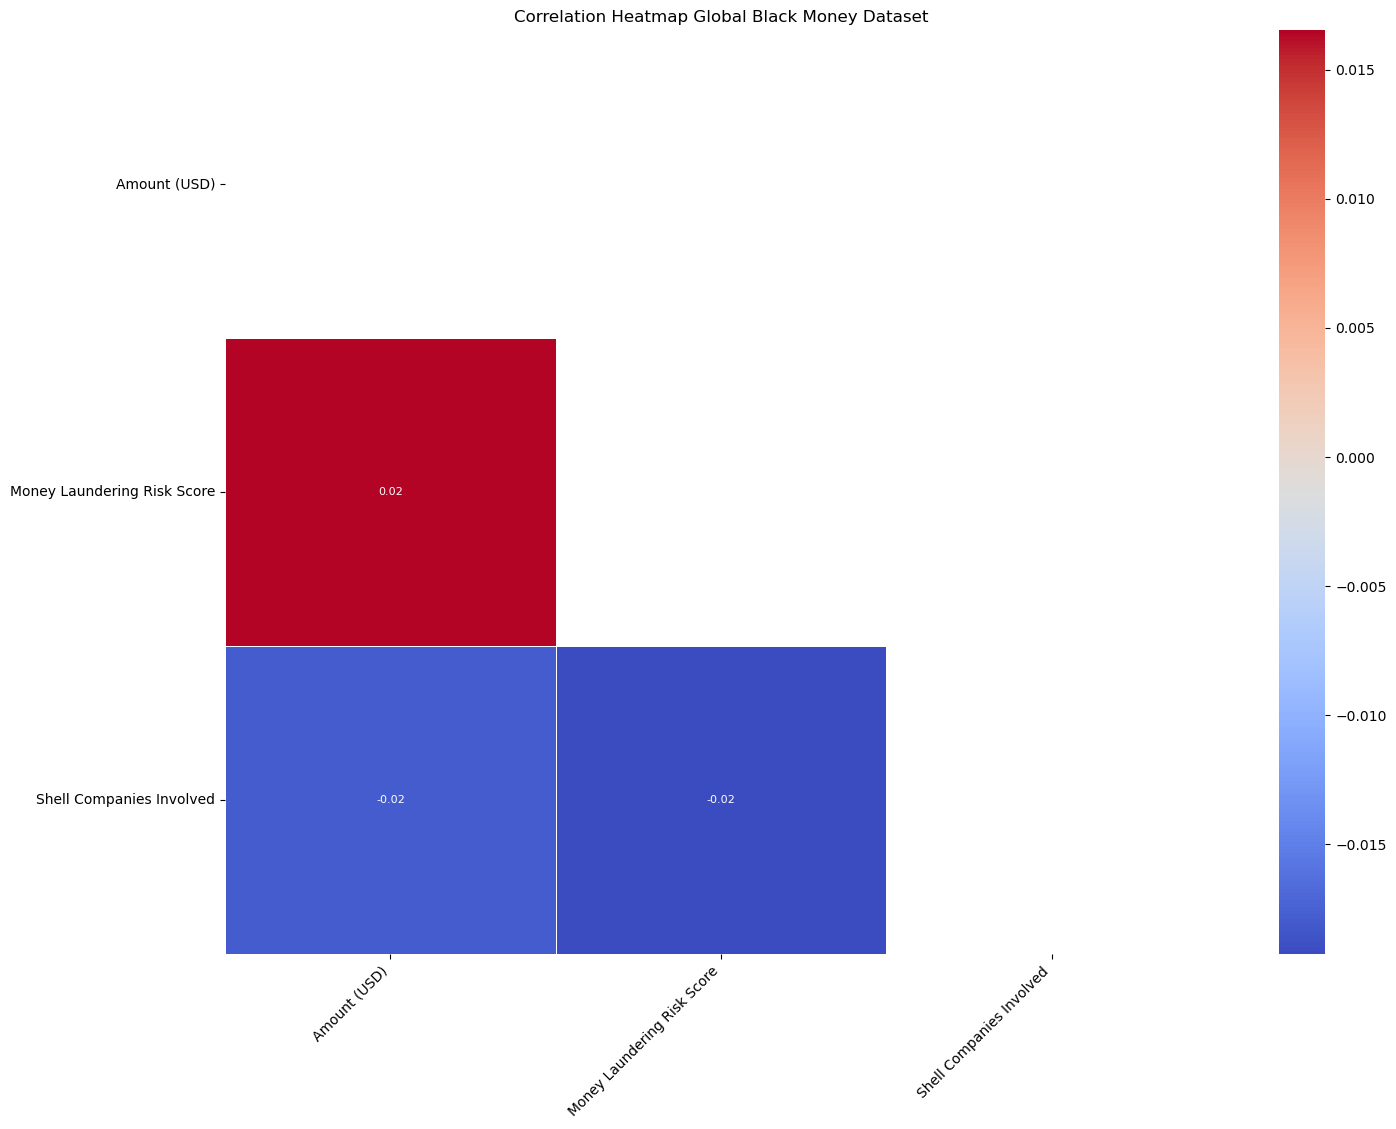

In [6]:
# Define Numeric Variables
numeric_predictors = ['Amount (USD)', 'Money Laundering Risk Score',  'Shell Companies Involved']

# Init Correlation Matrix
corr_matrix = df[numeric_predictors].corr()

# Create a heatmap
corr_matrix = corr_matrix

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})

# Rotate the x and y labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Heatmap Global Black Money Dataset')

# Show the heatmap
plt.show()

Source of Money
Illegal    7017
Legal      2983
Name: count, dtype: int64


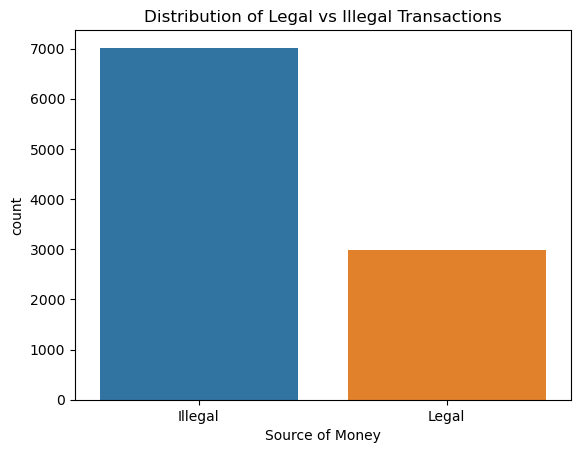

In [7]:
# Distribution of illegal vs legal transactions
print(df['Source of Money'].value_counts())

sns.countplot(x='Source of Money', data=df)
plt.title('Distribution of Legal vs Illegal Transactions')
plt.show()

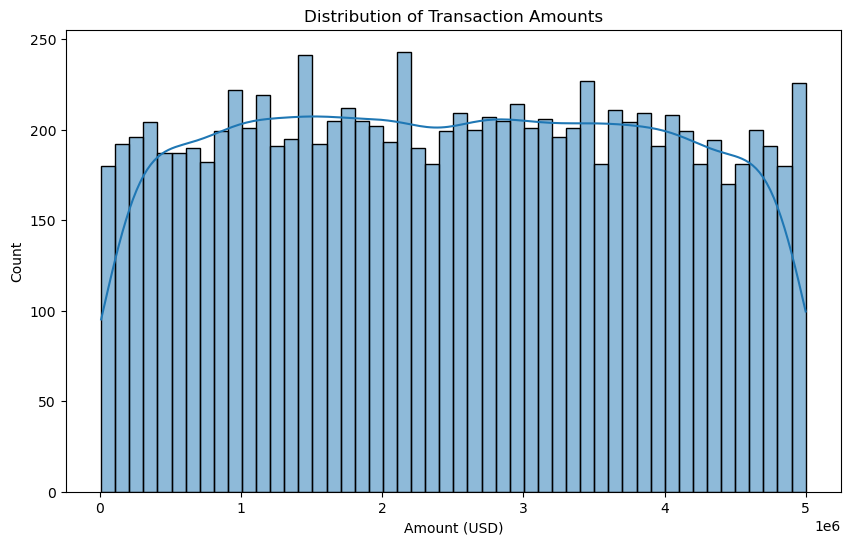

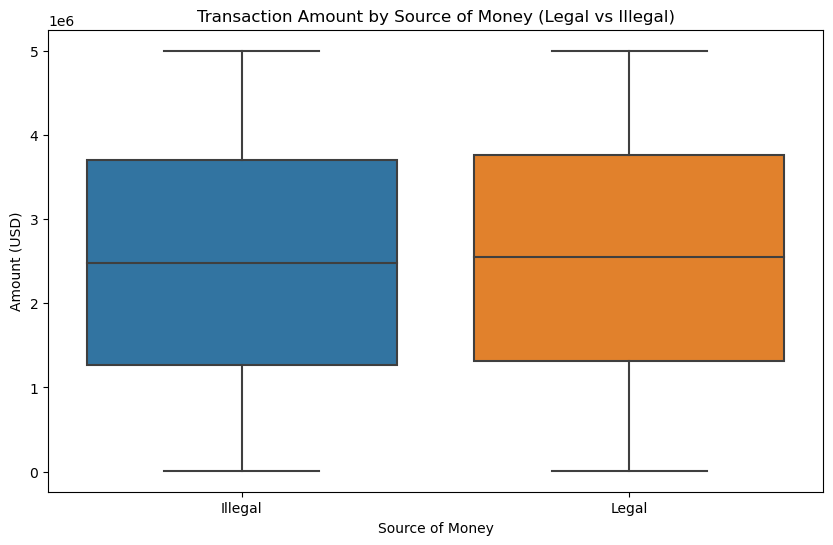

In [8]:
# Distribution of the overall transaction amounts
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount (USD)'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()

# Boxplot to compare Amount by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Amount (USD)', data=df)
plt.title('Transaction Amount by Source of Money (Legal vs Illegal)')
plt.show()

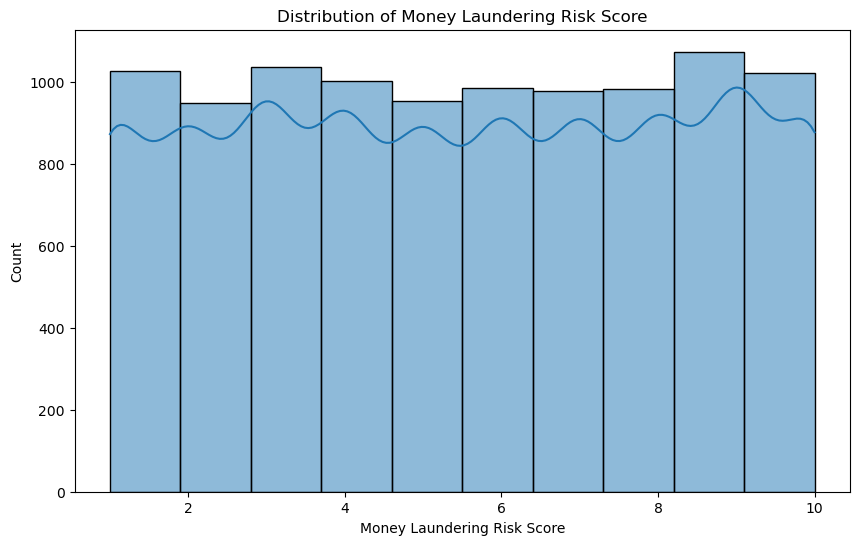

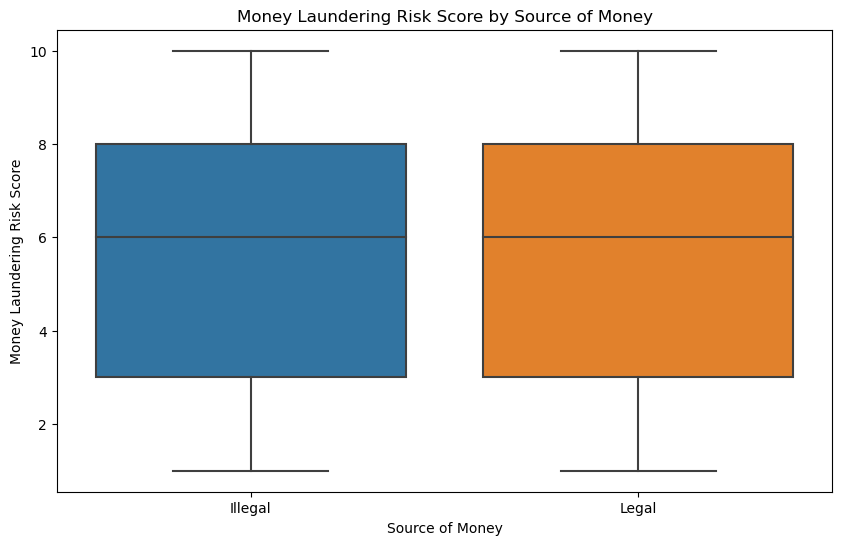

In [9]:
# Money Laundering Risk Score
plt.figure(figsize=(10, 6))
sns.histplot(df['Money Laundering Risk Score'], bins=10, kde=True)
plt.title('Distribution of Money Laundering Risk Score')
plt.show()

# Boxplot to compare Risk Score by Source of Money
plt.figure(figsize=(10, 6))
sns.boxplot(x='Source of Money', y='Money Laundering Risk Score', data=df)
plt.title('Money Laundering Risk Score by Source of Money')
plt.show()

Country
Brazil          748
South Africa    728
China           711
UK              708
Russia          701
India           695
Switzerland     687
UAE             685
Singapore       685
USA             669
Name: count, dtype: int64


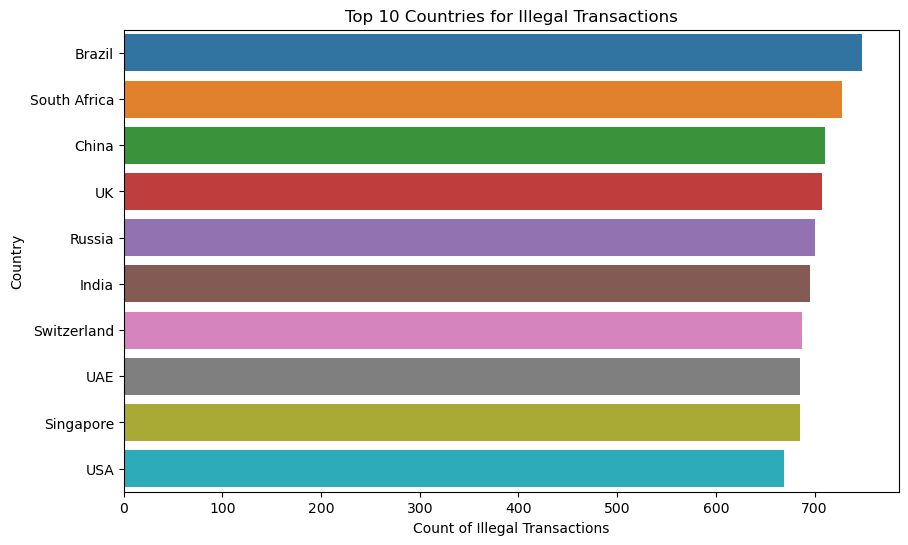

In [10]:
# Top countries for illegal transactions
illegal_countries = df[df['Source of Money'] == 'Illegal']['Country'].value_counts().head(10)
print(illegal_countries)

# top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x=illegal_countries.values, y=illegal_countries.index)
plt.title('Top 10 Countries for Illegal Transactions')
plt.xlabel('Count of Illegal Transactions')
plt.show()

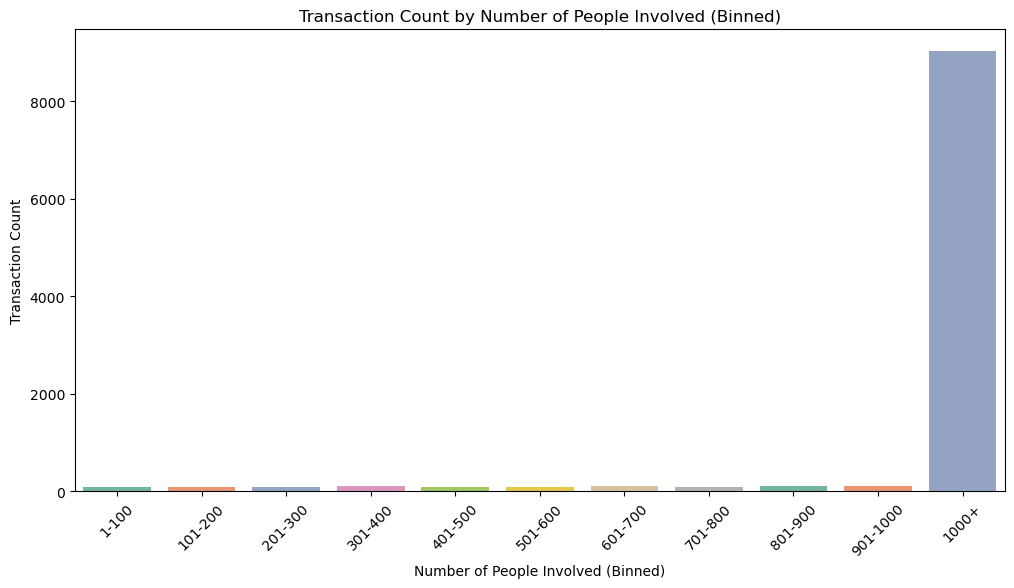

In [11]:
# Clean 'Person Involved' column by extracting numeric values from strings
df['Person Involved'] = pd.to_numeric(df['Person Involved'].str.extract('(\d+)')[0], errors='coerce')
df.dropna(subset=['Person Involved'], inplace=True)
df['Person Involved'] = df['Person Involved'].astype(int)

# Binning
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, df['Person Involved'].max()]  # Define bins
labels = ['1-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-700', '701-800', '801-900', '901-1000', '1000+']  # Define labels for the bins

# Create a new column for binned data
df['Person Involved Binned'] = pd.cut(df['Person Involved'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12, 6))
sns.countplot(x='Person Involved Binned', data=df, palette='Set2')
plt.title('Transaction Count by Number of People Involved (Binned)')
plt.xlabel('Number of People Involved (Binned)')
plt.ylabel('Transaction Count')
plt.xticks(rotation=45)
plt.show()


In [12]:
print(df.dtypes)

# Selecting categorical variables
categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Categorical Variables:', categorical_vars)

# Display unique values for categorical columns
for col in categorical_vars:
    print(f"{col}: {df[col].unique()}")

Transaction ID                         object
Country                                object
Amount (USD)                          float64
Transaction Type                       object
Date of Transaction            datetime64[ns]
Person Involved                         int64
Industry                               object
Destination Country                    object
Reported by Authority                    bool
Source of Money                        object
Money Laundering Risk Score             int64
Shell Companies Involved                int64
Financial Institution                  object
Tax Haven Country                      object
Transaction_Seconds                     int64
Person Involved Binned               category
dtype: object
Categorical Variables: ['Transaction ID', 'Country', 'Transaction Type', 'Industry', 'Destination Country', 'Source of Money', 'Financial Institution', 'Tax Haven Country', 'Person Involved Binned']
Transaction ID: ['TX0000000001' 'TX0000000002' 'TX0

In [13]:
# Convert 'Source of Money' to boolean (True for 'Illegal', False for 'Legal')
df['Source of Money'] = df['Source of Money'].map({'Illegal': True, 'Legal': False})


In [14]:
# Create dummy variables for categorical variables
df_dummies = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

# new DataFrame with dummy variables
print(df_dummies.head())

   Amount (USD) Date of Transaction  Person Involved  Reported by Authority  \
0  3.267530e+06 2013-01-01 00:00:00             1101                   True   
1  4.965767e+06 2013-01-01 01:00:00             7484                  False   
2  9.416750e+04 2013-01-01 02:00:00             3655                   True   
3  3.864201e+05 2013-01-01 03:00:00             3226                  False   
4  6.433784e+05 2013-01-01 04:00:00             7975                   True   

   Money Laundering Risk Score  Shell Companies Involved  Transaction_Seconds  \
0                            6                         1           1356998400   
1                            9                         0           1357002000   
2                            1                         3           1357005600   
3                            7                         2           1357009200   
4                            1                         9           1357012800   

   Transaction ID_TX0000000002  Transa

In [15]:
# Check for missing data
print(df.isnull().sum())

# Drop rows with missing values if needed
df.dropna(inplace=True)

Transaction ID                 0
Country                        0
Amount (USD)                   0
Transaction Type               0
Date of Transaction            0
Person Involved                0
Industry                       0
Destination Country            0
Reported by Authority          0
Source of Money                0
Money Laundering Risk Score    0
Shell Companies Involved       0
Financial Institution          0
Tax Haven Country              0
Transaction_Seconds            0
Person Involved Binned         1
dtype: int64


In [19]:
# Create df_clean by dropping rows with missing 'Person Involved'
df_clean = df.dropna(subset=['Person Involved'])

# Ensure that 'Person Involved' is treated as an integer
df_clean['Person Involved'] = df_clean['Person Involved'].astype(int)


In [20]:
# Use df_clean for features and ensure to select only numeric columns
X = df_dummies.loc[df_clean.index]  # Select only rows in df_clean

# Drop any non-numeric columns 
X_numeric = X.select_dtypes(include=[np.number])  # Keep only numeric columns


In [24]:
# Split the data
X = df_dummies.loc[df_clean.index]  # Use df_clean for consistent rows
y = df_clean['Source of Money']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Keep only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

# Scale the numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_numeric.loc[X_train.index])
X_test_scaled = scaler.transform(X_numeric.loc[X_test.index])


## Model 1

In [64]:
# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=2000, solver='liblinear')

# Fit model to scaled training data
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=2000, solver='liblinear')

In [66]:
# Make predictions on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Model Performance on Test Set:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model Performance on Test Set:
Accuracy: 0.7015
Precision: 0.7015
Recall: 1.0000
F1 Score: 0.8246


In [67]:
# Define hyperparameter grid to search
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],  # Solvers for regularization
    'penalty': ['l1', 'l2']           # L1 or L2 regularization
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='f1')

# Fit Grid Search to training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Re-train model with best parameters
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train_scaled, y_train)

Best hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


LogisticRegression(C=0.01, max_iter=1000, penalty='l1', solver='liblinear')

In [68]:
# Make predictions with tuned model
y_pred_tuned = best_log_reg.predict(X_test_scaled)

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

print('Tuned Model Performance on Test Set:')
print(f'Accuracy: {accuracy_tuned:.4f}')
print(f'Precision: {precision_tuned:.4f}')
print(f'Recall: {recall_tuned:.4f}')
print(f'F1 Score: {f1_tuned:.4f}')

Tuned Model Performance on Test Set:
Accuracy: 0.7015
Precision: 0.7015
Recall: 1.0000
F1 Score: 0.8246


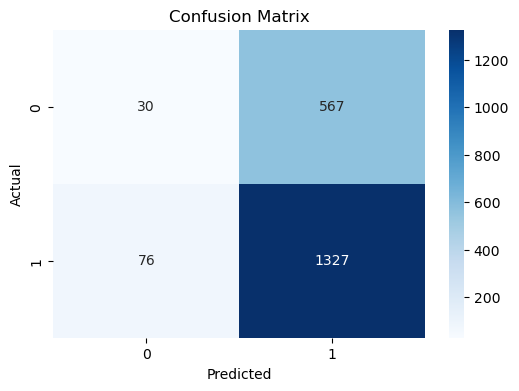

In [88]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [70]:
# Get coefficients from logistic regression model
coefficients = log_reg.coef_[0]

# Ensure we use scaled features for DataFrame
X_numeric_columns = X_numeric.columns  #only numeric features

# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_numeric_columns,
    'Coefficient': coefficients
})

# Sort DataFrame by coefficients
feature_importance.sort_values(by='Coefficient', ascending=False, inplace=True)
print(feature_importance)

                       Feature  Coefficient
1              Person Involved     0.050703
2  Money Laundering Risk Score     0.024457
3     Shell Companies Involved     0.014775
4          Transaction_Seconds     0.003070
0                 Amount (USD)    -0.011674


In [71]:
# Perform cross-validation
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='f1')
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean F1 Score: {cv_scores.mean():.4f}')

Cross-Validation F1 Scores: [0.82439383 0.82482556 0.82482556 0.82482556 0.8246968 ]
Mean F1 Score: 0.8247


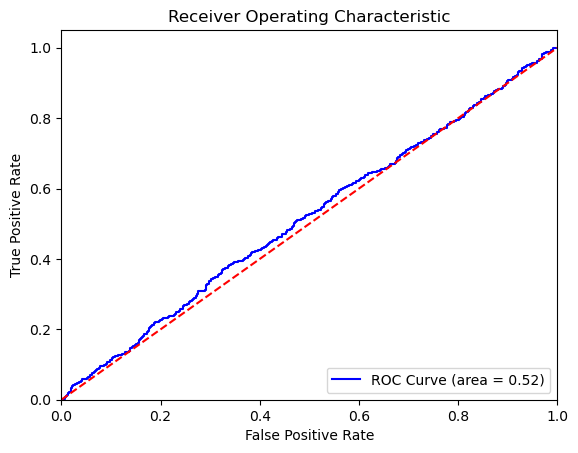

In [72]:
# Get predicted probabilities
y_scores = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model 2

In [89]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit model to scaled training data
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Model Performance on Test Set:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Model Performance on Test Set:
Accuracy: 0.6785
Precision: 0.5760
Recall: 0.6785
F1 Score: 0.5902


In [90]:
# Define hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit Grid Search to training data
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [91]:
# Re-train model with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train_scaled, y_train)

# Make predictions with tuned model
y_pred_tuned = best_rf_model.predict(X_test_scaled)

# Evaluate tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')
recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')

print('Tuned Model Performance on Test Set:')
print(f'Accuracy: {accuracy_tuned:.4f}')
print(f'Precision: {precision_tuned:.4f}')
print(f'Recall: {recall_tuned:.4f}')
print(f'F1 Score: {f1_tuned:.4f}')

Tuned Model Performance on Test Set:
Accuracy: 0.6995
Precision: 0.5416
Recall: 0.6995
F1 Score: 0.5784


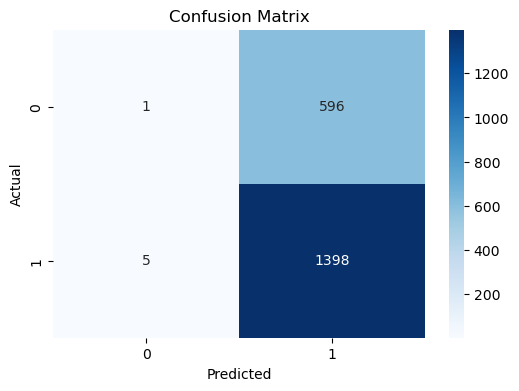

In [92]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [102]:
feature_names = ['Person Involved', 'Money Laundering Risk Score', 'Shell Companies Involved', 'Transaction_Seconds', 'Amount (USD)']

# Create the feature importance DataFrame
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance)

                       Feature  Importance
0              Person Involved    0.275637
1  Money Laundering Risk Score    0.270967
4                 Amount (USD)    0.268534
2     Shell Companies Involved    0.095850
3          Transaction_Seconds    0.089012


In [101]:
# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_train_scaled, y_train, cv=5, scoring='f1')
print(f'Cross-Validation F1 Scores: {cv_scores}')
print(f'Mean F1 Score: {cv_scores.mean():.4f}')

# Get predicted probabilities
y_scores = best_rf_model.predict_proba(X_test_scaled)[:, 1]  # Probability of the positive class

Cross-Validation F1 Scores: [0.82517483 0.825      0.82443872 0.82396178 0.82474227]
Mean F1 Score: 0.8247


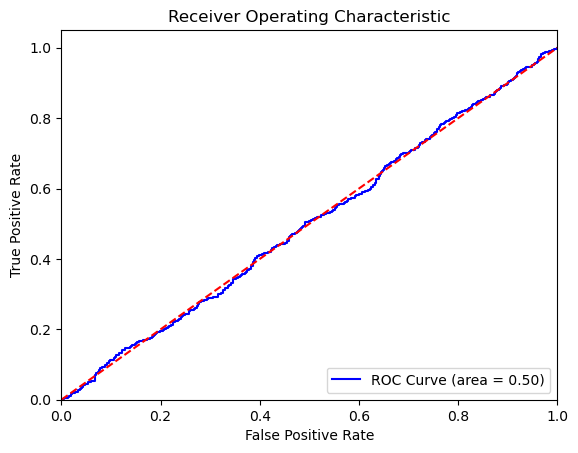

In [95]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Model 3